### Notebook to assess lagged changes in precip category in TC output, binned according to a 2D variable.

Assumes output is in a single netcdf file on pressure levels.

Writes out pickle files "pclass_itest_read_XXhrs.pkl"

James Ruppert  
jruppert@ou.edu  
12/18/23

### Main settings

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from thermo_functions import *
from scipy import stats
import seaborn as sns
from read_wrf_piccolo import *
from post_proc_functions import *
import xarray as xr
import pickle

In [12]:
# Write out pickle file?
do_write=True
do_write=False

case = "sept1-4"
tests_str = ["ctl", "ncrf12h"]
ntest = len(tests_str)

wrf_dom = "wrf_fine"
nmem = 5 # number of ensemble members

datdir = "/glade/derecho/scratch/ruppert/piccolo/"
# datdir = "/glade/campaign/univ/uokl0053/"
# datdir = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/piccolo/"
main_pickle = "/glade/work/ruppert/wrf-piccolo/python/pickle_save/"

# pclass_names = ['noncloud','deepc','congest','shallowc','strat','anvil']
pclass_names=["Non-cloud", "Deep", "Cong", "Shallow", "Strat", "Anvil", "Deep+Strat+Anvil"]
npclass=len(pclass_names)

# Ens-member string tags (e.g., memb_01, memb_02, etc.)
memb0=1 # Starting member to read
memb_nums_str=np.arange(memb0,nmem+memb0,1).astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

In [3]:
outdir, wrffiles, nfiles, npd = memb_dir_settings(datdir, case, tests_str[0], wrf_dom, memb_all[0])
lat1d, lon1d, nx1, nx2, nz, npd = wrf_dims(wrffiles[0])
pclass_file = xr.open_dataset(outdir+"pclass.nc")
times = pclass_file.Time
nt = pclass_file.Time.size
pclass_file.close()

### Main read loop

In [4]:
# Main read loops for 3D (dependent) variables

npts = nx1*nx2

# Arrays to save variables
dims = (ntest, nmem, nt, npclass)
pclass_area = np.full(dims, np.nan)

# pickle_file = main_pickle+'/pclass_'+test_str+'_'+memb_all[imemb]+'.pkl'
pickle_file = main_pickle+'pclass_area.pkl'

if do_write:

    for itest in range(ntest):

        test_str=tests_str[itest]
        print('Running test: ',test_str)

        # Time-offset between CTL and NCRF
        if test_str == "ncrf12h":
            t_offset = 36
        else:
            t_offset = 0

        # Loop over ensemble members

        for imemb in range(nmem):

            outdir, wrffiles, nfiles, npd = memb_dir_settings(datdir, case, test_str, wrf_dom, memb_all[imemb])

            # PCLASS index
            pclass_file = xr.open_dataset(outdir+"pclass.nc")
            pclass = pclass_file.pclass.values
            i_nt = pclass.shape[0]
            pclass_file.close()

            for it in range(i_nt):
                for ipclass in range(npclass):
                    if ipclass < 6:
                        indices = (pclass[it,...] == ipclass).nonzero()
                    else: # MCS category
                        indices = (np.bitwise_or((pclass[it,...] == 1), (pclass[it,...] >= 4))).nonzero()
                    pclass_area[itest,imemb,it+t_offset,ipclass] = indices[0].shape[0]/npts

    with open(pickle_file, 'wb') as file:
        pickle.dump(pclass_area, file)
else:
    with open(pickle_file, 'rb') as file:
        pclass_area = pickle.load(file)

---
### Plotting routines

#### Plotting functions

In [5]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [6]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    # conf_set=0.95 # Confidence interval to apply throughout
    conf_set=0.9 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

In [7]:
# Smooth time series
# Assumes f = f(nmem, nt), smooths only over 2nd dimension
def smooth_tser(invar):
    invar_sm = np.copy(invar)
    invar_sm[:,1:-1] = (invar_sm[:,2:] + invar_sm[:,1:-1] + invar_sm[:,0:-2])/3
    return invar_sm

#### P-Class area time series

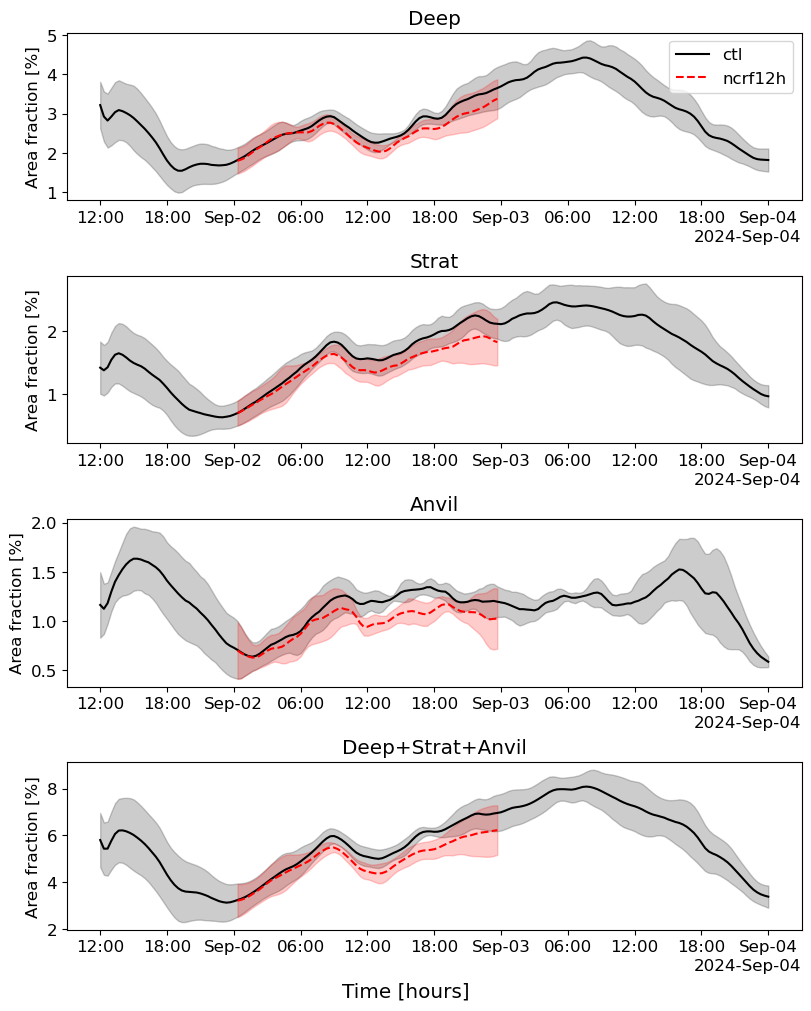

In [13]:
xmax=nt
# xmax=12

# Plot as difference from CTL?
i_ctldiff=True
# i_ctldiff=False

# Standardize?
i_standardize=True
i_standardize=False

# XX Average ensemble members
# pltvar = np.mean(pclass_area, axis=1)
pltvar = np.copy(pclass_area)

# As difference from CTL-ens-mean
ctl=np.mean(pltvar[0], axis=0)
if i_ctldiff:
        pltvar -= ctl[np.newaxis,np.newaxis,...]
pltvar_anom = pltvar*1e2

ylabel='Area fraction [%]'
if i_standardize:
        # XX Normalize by mean for each pclass
        # Standardize using STD from all pclass, ensemble members
        stddev = np.std(pltvar,axis=(0,1,2))
        stddev_ctl = np.std(pltvar[0],axis=(0,1))
        # pltvar_anom = pltvar_anom/stddev[np.newaxis,np.newaxis,np.newaxis,:]
        pltvar_anom = pltvar_anom/stddev_ctl[np.newaxis,np.newaxis,np.newaxis,:]
        ylabel='Standardized\nDifference from CTL'

linecolor=['black', 'red', 'blue', 'green', 'green']
linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
linestyle[-1]='dashed'

# create figure

# ipclass_plot=np.arange(npclass)
# ipclass_plot=[1,2,3,4,5]
ipclass_plot=[1,4,5,6]
npclass_plot=len(ipclass_plot)

fig_x = 8
# fig_y = 14
fig_y = 10
fig, ax = plt.subplots(npclass_plot,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column

fig.supxlabel('Time [hours]')

for ipclass in range(npclass_plot):

        ipclass_data=ipclass_plot[ipclass]

        # create figure
        # fig = plt.figure(figsize=(14,4))
        # ax = fig.add_subplot(111)

        fig_title = pclass_names[ipclass_data]
        ax[ipclass].set_title(fig_title)

        for itest in range(ntest):
                ipvar=pltvar_anom[itest,:,:,ipclass_data]
                ipvar_sm = smooth_tser(ipvar)
                # ipvar_sm = np.copy(ipvar)
                mean, low, high = mean_confidence_interval(ipvar_sm)
                ax[ipclass].plot(times, mean[:xmax], label=tests_str[itest],
                         color=linecolor[itest], linestyle=linestyle[itest])
                # if itest <= 1:
                ax[ipclass].fill_between(times, high[:xmax], low[:xmax], alpha=0.2, color=linecolor[itest])
                # ax[ipclass].set_ylim(-3,1)

        ax[ipclass].set_ylabel(ylabel)

        # Time labels
        ax[ipclass].xaxis.set_major_locator(mdates.AutoDateLocator())
        ax[ipclass].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[ipclass].xaxis.get_major_locator()))

# if ipclass == 0:
ax[0].legend()#loc="lower left")

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()

#### Area ratio

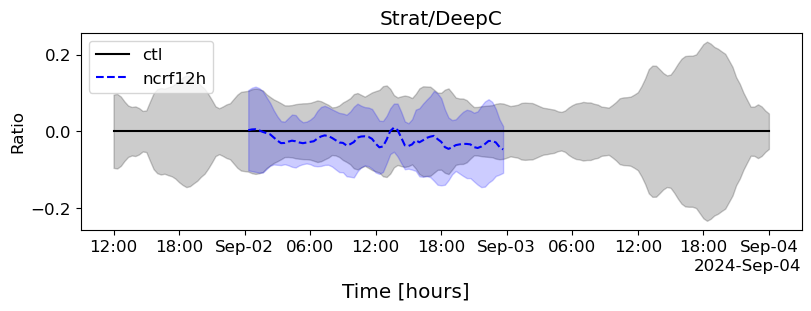

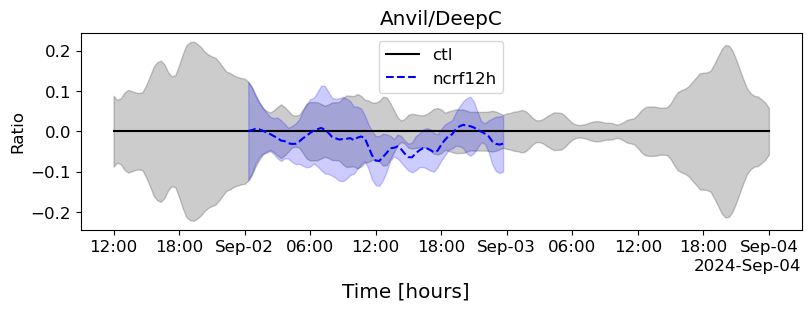

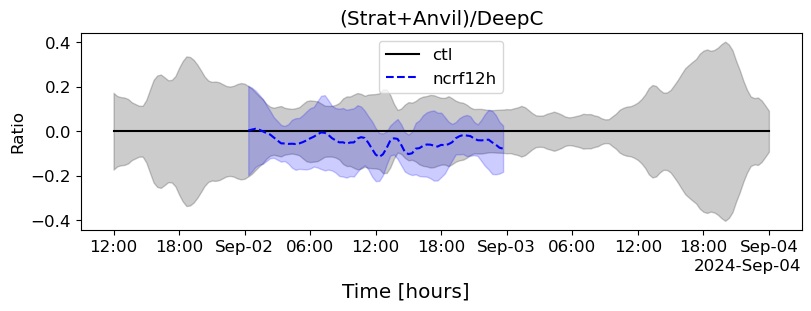

In [9]:
xmax=nt
# xmax=12

# Plot as difference from CTL?
i_ctldiff=True
# i_ctldiff=False

# Standardize?
i_standardize=True
i_standardize=False

for iratio in range(3):

        if iratio == 0:
                fig_title = 'Strat/DeepC'
                pltvar = pclass_area[:,:,:,4]/pclass_area[:,:,:,1] # Strat / Conv
        elif iratio == 1:
                fig_title = 'Anvil/DeepC'
                pltvar = pclass_area[:,:,:,5]/pclass_area[:,:,:,1] # Anvil / Conv
        elif iratio == 2:
                fig_title = '(Strat+Anvil)/DeepC'
                pltvar = (pclass_area[:,:,:,4] + pclass_area[:,:,:,5])/pclass_area[:,:,:,1] # Strat+Anvil / Conv

        # As difference from CTL-ens-mean
        ctl=np.mean(pltvar[0], axis=0)
        pltvar_anom = pltvar
        if i_ctldiff:
                pltvar_anom -= ctl[np.newaxis,np.newaxis,...]

        ylabel='Ratio'
        if i_standardize:
                # XX Normalize by mean for each pclass
                # Standardize using STD from all ensemble members
                stddev = np.std(pltvar,axis=(0,1))
                stddev_ctl = np.std(pltvar[0],axis=0)
                # pltvar_anom = pltvar_anom/stddev[np.newaxis,np.newaxis,np.newaxis,:]
                pltvar_anom = pltvar_anom/stddev_ctl[np.newaxis,np.newaxis,:]
                ylabel='Standardized\nDifference from CTL'

        linecolor=['black', 'blue', 'red', 'green', 'green']
        linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
        linestyle[-1]='dashed'

        # create figure

        # ipclass_plot=np.arange(npclass)
        # ipclass_plot=[1,2,3,4,5]
        ipclass_plot=[1,4,5]
        npclass_plot=len(ipclass_plot)

        fig_x = 8
        # fig_y = 14
        fig_y = 3
        fig, ax = plt.subplots(1,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column

        fig.supxlabel('Time [hours]')

        # create figure
        # fig = plt.figure(figsize=(14,4))
        # ax = fig.add_subplot(111)

        ax.set_title(fig_title)

        for itest in range(ntest):
                ipvar=pltvar_anom[itest,:,:]
                ipvar_sm = smooth_tser(ipvar)
                # ipvar_sm = np.copy(ipvar)
                mean, low, high = mean_confidence_interval(ipvar_sm)
                ax.plot(times, mean[:xmax], label=tests_str[itest],
                                color=linecolor[itest], linestyle=linestyle[itest])
                if itest <= 1:
                        ax.fill_between(times, high[:xmax], low[:xmax], alpha=0.2, color=linecolor[itest])
        # ax.set_ylim(-3,1)

        ax.set_ylabel(ylabel)

        # Time labels
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

        # if ipclass == 0:
        ax.legend()#loc="lower left")

        #     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #                 bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()